In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import warnings
warnings.filterwarnings("ignore")
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Layer




from skimage.morphology import label
from skimage.io import imread
from numpy import expand_dims

from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight


import os
import time
import sys

Using TensorFlow backend.


In [2]:
import random

In [3]:

from mrcnn.visualize import display_instances
from mrcnn.visualize import display_top_masks
from mrcnn.utils import extract_bboxes
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import mrcnn.model as modellib



In [4]:
DATA_DIR = './input/airbus-ship-detection'

# Directory to save logs and trained model
ROOT_DIR = './working'
debug = False
train_dicom_dir = os.path.join(DATA_DIR, 'train_v2')
test_dicom_dir = os.path.join(DATA_DIR, 'test_v2')

In [5]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64,1)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [7]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dicom_dir) if f not in exclude_list]

print(len(train_names), len(test_names))

0 1


In [8]:
class DetectorDataset(Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [9]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
best_epoch=1

In [11]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model ./working\airbus20181115T0033\mask_rcnn_airbus_0022.h5


In [12]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  ./working\airbus20181115T0033\mask_rcnn_airbus_0022.h5
Re-starting from epoch 22


# Validation Data set

In [27]:
DETECTION_TEST_PRED = './ship_detection.csv'
ship_detection = pd.read_csv(DETECTION_TEST_PRED, index_col='id')
ship_detection.head()

,p_ship
id,
51e9beaca.jpg,0.053764
0a4d97295.jpg,0.412521
c175e03b9.jpg,0.007387
8a56c9bdd.jpg,0.999422
MicrosoftTeams-image (11).jpg,0.677000


# Use model on images to test!
After this point the model is already loaded and ready to use (I think)

In [15]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm(image_fps):
            found = False
            
            if image_id not in test_names_nothing:
                image = imread(os.path.join(test_dicom_dir, image_id))
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
#                 image, window, scale, padding, crop = utils.resize_image(
#                     image,
#                     min_dim=config.IMAGE_MIN_DIM,
#                     min_scale=config.IMAGE_MIN_SCALE,
#                     max_dim=config.IMAGE_MAX_DIM,
#                     mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]

                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass  ## no ship
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                            file.write(image_id + "," + rle_encode(r['masks'][...,i]) + "\n")
                            found = True

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [16]:
def visualize_test(id): 
    image_id = id #random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dicom_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)
    ax2.set_title(f"{len(r['rois'])} masks if prob:{ship_detection.loc[image_id][0]:.6f}")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels']))


In [21]:
import cv2

NameError: name 'sub' is not defined

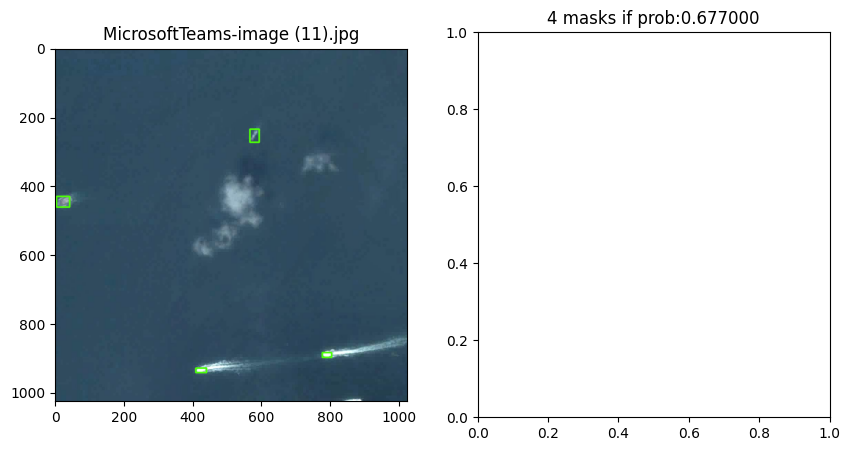

In [28]:
visualize_test("MicrosoftTeams-image (11).jpg")

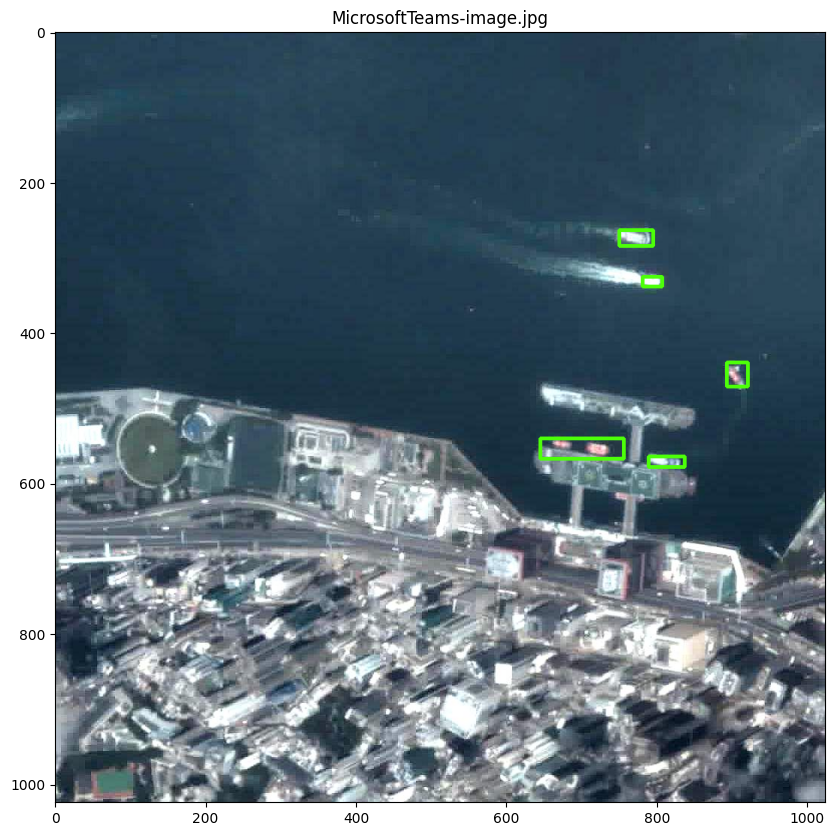

In [32]:
def visualize_test2(id): 
    image_id = id #random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dicom_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)

visualize_test2("MicrosoftTeams-image.jpg")